<a href="https://colab.research.google.com/github/EasonChen78/machine_learning/blob/main/20230428_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import zipfile
path = "/content/drive/MyDrive/Colab Notebooks/train.zip"
f = zipfile.ZipFile(path)
f.extractall()

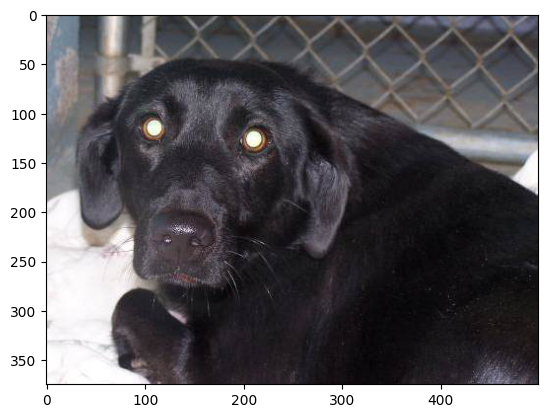

In [3]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
fs = glob.glob("train/*")
plt.imshow(Image.open(fs[2000]))

In [4]:
import random
import pandas as pd
dogs = glob.glob("train/dog.*")
random.shuffle(dogs)
cats = glob.glob("train/cat.*")
random.shuffle(cats)
train = pd.DataFrame({
    "filename":dogs[:900] + cats[:900],
    "class":["dog"] * 900 + ["cat"] * 900
})
validate = pd.DataFrame({
    "filename":dogs[900:950] + cats[900:950],
    "class":["dog"] * 50 + ["cat"] * 50
})
test = pd.DataFrame({
    "filename":dogs[950:1000] + cats[950:1000],
    "class":["dog"] * 50 + ["cat"] * 50
})
train

,filename,class
0,train/dog.2064.jpg,dog
1,train/dog.10038.jpg,dog
2,train/dog.1438.jpg,dog
3,train/dog.7894.jpg,dog
4,train/dog.12042.jpg,dog
...,...,...
1795,train/cat.242.jpg,cat
1796,train/cat.8829.jpg,cat
1797,train/cat.10734.jpg,cat
1798,train/cat.7088.jpg,cat


In [5]:
# generater概念解釋
r = range(500000000000000)
it = r.__iter__()
it.__next__()
it.__next__()
it.__next__()

2

In [6]:
# 自製generator
def tst():
  l = [70, 80, 90]
  for n in l:
    yield n ** 2
# t = test()
# t.__next__()
# t.__next__()
# t.__next__()
# t.__next__()
for i in tst():
  print(i)


4900
6400
8100


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
# 資料增強: zoom:放大(1.2) shear:偏斜(0.2) 水平翻轉
train_datagen = ImageDataGenerator(
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, preprocessing_function=preprocess_input
)
# 測試資料是沒有動的
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

training_set = train_datagen.flow_from_dataframe(
    train,
    ".",
    # 每一張圖片都縮到(224, 224)  根據當初imagenet的訓練格式調整
    target_size=(224, 224),
    # 一次給我32張
    batch_size=32,
    class_mode="sparse") # 參數sparse，會自動將dog和cat，置換成0和1
validate_set = test_datagen.flow_from_dataframe(
    test,
    ".",
    # 每一張圖片都縮到(224, 224)
    target_size=(224, 224),
    # 一次給我32張
    batch_size=32,
    class_mode="sparse")
test_set = test_datagen.flow_from_dataframe(
    validate,
    ".",
    # 每一張圖片都縮到(224, 224)
    target_size=(224, 224),
    # 一次給我32張
    batch_size=32,
    class_mode="sparse")

Found 1800 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [20]:
training_set.__next__()[0]

array([[[[-100.939     , -113.779     , -120.68      ],
         [-100.939     , -113.779     , -120.68      ],
         [-100.939     , -113.779     , -120.68      ],
         ...,
         [ -49.45324   ,  -77.306366  ,  -87.24675   ],
         [ -75.90349   ,  -95.75442   ,  -99.66361   ],
         [ -75.939     ,  -95.779     ,  -99.68      ]],

        [[-100.939     , -113.779     , -120.68      ],
         [-100.939     , -113.779     , -120.68      ],
         [-100.939     , -113.779     , -120.68      ],
         ...,
         [ -49.55318   ,  -77.4036    ,  -87.33589   ],
         [ -75.939     ,  -95.779     ,  -99.68      ],
         [ -75.939     ,  -95.779     ,  -99.68      ]],

        [[-100.939     , -113.779     , -120.68      ],
         [-100.939     , -113.779     , -120.68      ],
         [-100.939     , -113.779     , -120.68      ],
         ...,
         [ -54.291645  ,  -81.22174   ,  -93.942     ],
         [ -74.07495   ,  -94.84697   , -101.54405   ],
  

(32, 224, 224, 3)


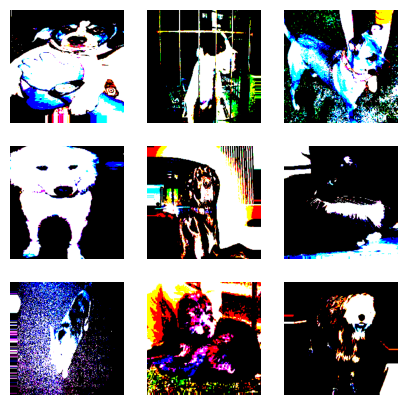

In [9]:
# 秀出訓練資料被數據增強以後產生的圖片
import matplotlib.pyplot as plt
batch = training_set.__next__()[0]
print(batch.shape)
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[i])
    plt.axis("off")

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization
for l in vgg.layers:
    l.trainable = False
layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
layers = vgg.layers + layers
model = Sequential(layers)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [22]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

In [23]:
# 控制訓練次數: 控制過擬合程度
# 不希望死背/看稀少, 檢查test
# 訓練次數過多反而會變差
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    ModelCheckpoint("cnn.h5", save_best_only=True),
    # 檢查test資料, 如果我10次都沒有表現更好, 停
    EarlyStopping(patience=10, restore_best_weights=True)
]
# 不想要進度條, verbose=2
model.fit(training_set,
     epochs=150,
     validation_data=validate_set,
     callbacks=callbacks) 
# 這邊每個 epoch 都會分批次(每次32張)，拿完 training_set 的 1800 張圖片(包含每張圖另外生成的強化圖 900x2) 

Epoch 1/150
57/57 [==============================] - 1303s 23s/step - loss: 0.3907 - accuracy: 0.8500 - val_loss: 0.1896 - val_accuracy: 0.9100
Epoch 2/150
57/57 [==============================] - 1295s 23s/step - loss: 0.1883 - accuracy: 0.9556 - val_loss: 0.1108 - val_accuracy: 0.9700
Epoch 3/150
57/57 [==============================] - 1276s 22s/step - loss: 0.1476 - accuracy: 0.9583 - val_loss: 0.0847 - val_accuracy: 0.9800
Epoch 4/150
57/57 [==============================] - 1260s 22s/step - loss: 0.1200 - accuracy: 0.9656 - val_loss: 0.0680 - val_accuracy: 0.9900
Epoch 5/150
57/57 [==============================] - 1306s 23s/step - loss: 0.1113 - accuracy: 0.9678 - val_loss: 0.0588 - val_accuracy: 0.9900
Epoch 6/150
57/57 [==============================] - 1288s 23s/step - loss: 0.1055 - accuracy: 0.9656 - val_loss: 0.0548 - val_accuracy: 0.9900
Epoch 7/150


KeyboardInterrupt: ignored

In [24]:
model.evaluate(x=test_set)

4/4 [==============================] - 65s 15s/step - loss: 0.0588 - accuracy: 0.9800


[0.05882886424660683, 0.9800000190734863]

In [ ]:
import requests
# pillow
from PIL import Image
url = input("url:")
response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB").resize((224, 224))
img_np = np.array(img).reshape(1, 224, 224, 3)
# (32, 32, 3) -> (1, 32, 32, 3)
img_np_pre = preprocess_input(img_np)
proba = model.predict(img_np_pre)[0]
for p, n in zip(proba, trans):
    print(n, "的機率:", round(p, 3))
plt.imshow(img)